# Otizm Spektrum Bozukluğu (OSB) Tahmini

CDC'ye ([Hastalık Kontrol ve Önleme Merkezi](https://www.cdc.gov/ncbddd/autism/facts.html)) göre, Otizm spektrum bozukluğu (OSB) şöyle tanımlanır:

Otizm spektrum bozukluğu (OSB), önemli sosyal, iletişimsel ve davranışsal zorluklara neden olabilen bir gelişimsel bozukluktur. OSB olan kişilerin görünüşlerinde genellikle diğer insanlardan ayırt edici bir şey yoktur, ancak OSB olan kişiler iletişim kurabilir, etkileşimde bulunabilir, davranabilir ve öğrenebilirler ki bu, çoğu diğer insanlardan farklı olabilir. OSB'li kişilerin öğrenme, düşünme ve problem çözme yetenekleri, yetenekli olanlardan çok zorluk çekenlere kadar değişebilir. OSB'li bazı insanlar günlük yaşamlarında çok fazla yardıma ihtiyaç duyarlar; diğerleri daha az yardıma ihtiyaç duyarlar.

OSB teşhisi artık eskiden ayrı ayrı teşhis edilen birkaç durumu içerir: otistik bozukluk, başka türlü belirtilmemiş yaygın gelişimsel bozukluk (PDD-NOS) ve Asperger sendromu. Bu durumlar artık tümü otizm spektrum bozukluğu olarak adlandırılır."

**Veri kümesi**: Veri kümesi, bir uygulama formu dolduran kişilerin anket sonuçlarından oluşmaktadır. Kişinin otizm teşhisi alıp almadığını gösteren etiketler bulunmaktadır.

#### Amaç: Verilen özelliklere dayanarak otizm olasılığını tahmin etmek için makine öğrenimi modelleri oluşturmak

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
pio.templates.default = "none"

import warnings
warnings.filterwarnings('ignore')


PATH = 'C:/Users/mert_/PycharmProjects/autisim_project/models/data'
train = pd.read_csv(PATH + "/train.csv")
test = pd.read_csv(PATH + "/test.csv")

    ### Veri Şekli
* Eğitim verisi: 800 satır, 21 sütun
* Test verisi: 200 satır, 21 sütun

In [33]:
display(train.shape)
display(test.shape)

(800, 22)

(200, 21)

### Test verisinin ilk satırları

Aşağıda veri setlerinin sütun açıklamaları bulunmaktadır:

- ID - Hastanın kimlik numarası
- A1_Score ile A10_Score - Otizm Spektrum Belirtileri (AQ) 10 madde tarama aracı bazında puan
- age - Hastanın yaşı (yıl olarak)
- gender - Hastanın cinsiyeti
- ethnicity - Hastanın etnik kökeni
- jaundice - Doğumda sarılık geçirip geçirmediği
- autism - Ailede otizm teşhisi konmuş bir birey olup olmadığı
- contry_of_res - Hastanın ikamet ettiği ülke
- used_app_before - Hastanın daha önce bir tarama testine girip girmediği
- result - AQ1-10 tarama testi puanı
- age_desc - Hastanın yaşı
- relation - Testi dolduran hastanın yakını
- Class/ASD - 0 veya 1 olarak sınıflandırılmış sonuç. Burada 0 "Hayır", 1 "Evet" anlamına gelir. Bu hedef sütundur ve gönderim sırasında sadece 0 veya 1 olarak değerler gönderilmelidir.

In [34]:
train.head() # train datasinin ilk birkac satirini goruyoruz.

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,1,1,1,0,1,1,...,f,White-European,no,no,United States,no,7.819715,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,f,South Asian,no,no,Australia,no,10.544296,18 and more,?,0
2,3,1,1,1,1,1,1,0,0,1,...,f,White-European,no,no,United Kingdom,no,13.167506,18 and more,Self,1
3,4,0,0,0,1,0,0,0,0,0,...,f,South Asian,no,no,New Zealand,no,1.530098,18 and more,?,0
4,5,0,0,0,0,1,0,0,0,1,...,m,Black,no,yes,Italy,no,7.949723,18 and more,Self,0


### Veri temizleme

In [35]:
# yanlis yazilma hatalari duzeltildi
train = train.rename(columns = {'austim': 'autism', 'contry_of_res':'country_of_res'}, errors="raise")
test = test.rename(columns = {'austim': 'autism', 'contry_of_res':'country_of_res'}, errors="raise")

# buyuk/kucuk harf hatalari duzeltildi 
train['country_of_res'][train['country_of_res'] == 'others'] = 'Others'
test['country_of_res'][test['country_of_res'] == 'others'] = 'Others'

train['ethnicity'][train['ethnicity'] == 'others'] = 'Others'
test['ethnicity'][test['ethnicity'] == 'others'] = 'Others'

In [36]:
# onemsiz sutunlar veriden kaldirildi
train.drop(['ID', 'age_desc'], axis=1, inplace=True)
test.drop(['ID', 'age_desc'], axis=1, inplace=True)

cat_cols = [col for col in train.columns if train[col].dtype == 'object']
num_cols = [col for col in train.columns if train[col].dtype == 'int'][0:-1]

ASD_pos = train[train['Class/ASD']==1]
ASD_neg = train[train['Class/ASD']==0]

### Kategorik özelliklerin benzersizliğini kontrol etme
- Sadece ikamet edilen ülke sütunu eğitim (61) ve test (44) veri setlerinde farklı benzersiz değerlere sahiptir.

In [61]:
from sklearn.model_selection import train_test_split

Y = train[['Class/ASD']] # train -> y
X = train.drop(['Class/ASD'], axis=1) # train -> x


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(640, 19) (160, 19) (640, 1) (160, 1)


In [38]:
for col in cat_cols:
    x = train[col].nunique() 
    y = test[col].nunique()
    print("{}: train {} unique, test {} unique".format(col, x, y))

gender: train 2 unique, test 2 unique
ethnicity: train 11 unique, test 11 unique
jaundice: train 2 unique, test 2 unique
autism: train 2 unique, test 2 unique
country_of_res: train 61 unique, test 44 unique
used_app_before: train 2 unique, test 2 unique
relation: train 6 unique, test 6 unique


In [39]:
sorted(train['country_of_res'].unique())

['Afghanistan',
 'AmericanSamoa',
 'Angola',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Belgium',
 'Bolivia',
 'Brazil',
 'Canada',
 'China',
 'Costa Rica',
 'Cyprus',
 'Czech Republic',
 'Ecuador',
 'Egypt',
 'Ethiopia',
 'Finland',
 'France',
 'Germany',
 'Hong Kong',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Italy',
 'Japan',
 'Jordan',
 'Kazakhstan',
 'Malaysia',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Nicaragua',
 'Niger',
 'Oman',
 'Pakistan',
 'Philippines',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Serbia',
 'Sierra Leone',
 'South Africa',
 'Spain',
 'Sri Lanka',
 'Sweden',
 'Tonga',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 'Uruguay',
 'Viet Nam']

### Özelliklerin dağılımı
### Hedef: ASD Sınıfı
- Hedefin yaklaşık %77'si ASD negatif (0) ve %23'ü ASD pozitif (1)
- Hedef sınıf dengeli değil.

In [40]:
label = ['ASD Positive (=1)', 'ASD Negative (=0)']
value = [ASD_pos.shape[0], ASD_neg.shape[0]]
pct = [value[0]*100/len(train), value[1]*100/len(train)]


fig = go.Figure(data=[go.Bar(
    y=value, x=label,
    text=(np.round(pct,2)),
    textposition=['outside', 'inside'],
    texttemplate = ["<b style='color: #f'>%{text}%</b>"]*2,
    textfont=dict(  family="sans serif",
                    size=16,
                    color="black"),
    orientation='v',
    marker_color=['purple', 'lightsalmon'],
    opacity=1.0,
)])
fig.update_layout(title='<b>Target: ASD Class <b>',
                  font_family="San Serif",
                  template= 'simple_white',
                  yaxis_linewidth=2.5,
                  width=600,
                  height=400,
                  bargap=0.2,
                  barmode='group',
                  titlefont={'size': 20},
                  )
fig.update_xaxes(showgrid=False, showline=True)
fig.update_yaxes(showgrid=True, showline=True, showticklabels=True, ticks='')
fig.show()

### Cinsiyet
- Cinsiyet dağılımı oldukça dengeli. %52'si kadın (f) ve geri kalan %48'i erkek (m).
- ASD pozitif olanların %63'ü kadın.

In [41]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=ASD_pos['gender'],histnorm='percent',
                           name='ASD_pos', marker_color = 'purple'),
              )
fig.add_trace(go.Histogram(x=ASD_neg['gender'],histnorm='percent',
                           name='ASD_neg', marker_color = 'salmon', opacity=0.85),
              )

fig.update_layout(title="Gender of the patient",
                  font_family="San Serif",
                  titlefont={'size': 20},
                  template='simple_white',
                  width=600,
                  height=400,
                  legend=dict(
                      orientation="v", y=1, yanchor="top", x=1.20, xanchor="right" )
                  ).update_xaxes(categoryorder='total descending')
fig.show()

### Etnik Köken
- Veride "?" ve diğerleri dahil olmak üzere 11 etnik kategori bulunmaktadır.
- En büyük gruplar sırasıyla Beyaz-Avrupalı, "?", Asyalı ve Orta Doğulu.
- ASD pozitif kişiler arasında Beyaz-Avrupalılar %58 ile çoğunluktayken, toplam örneğin (eğitim verisi) sadece %26'sını oluşturur. İkinci sırada %9 ile Asyalılar, üçüncü sırada ise %8 ile Latinler ve "?" yer alır.

In [42]:
fig = px.histogram(train, x="ethnicity",
                   width=600,
                   height=400,
                   histnorm='percent',
                   template="simple_white"
                   )

fig.update_layout(title="Ethnic group of the patient",
                  font_family="San Serif",
                  titlefont={'size': 20},
                  legend=dict(
                      orientation="v", y=1, yanchor="top", x=1.0, xanchor="right" )
                  ).update_xaxes(categoryorder='total descending') # ordering the x-axis values
#custom color
colors = ['lightgray',] * 15
colors[1] = 'crimson'
colors[0] = 'lightseagreen'


fig.update_traces(marker_color=colors,
                  )
fig.show()

fig = go.Figure()
fig.add_trace(go.Histogram(x=ASD_pos['ethnicity'],histnorm='percent',
                           name='ASD_pos', marker_color = 'purple'),
              )
fig.add_trace(go.Histogram(x=ASD_neg['ethnicity'],histnorm='percent',
                           name='ASD_neg', marker_color = 'salmon', opacity=0.85),
              )

fig.update_layout(title="Ethnic group of the patient",
                  font_family="San Serif",
                  titlefont={'size': 20},
                  template='simple_white',
                  width=600,
                  height=400,
                  legend=dict(
                      orientation="v", y=1, yanchor="top", x=1.0, xanchor="right" )
                  ).update_xaxes(categoryorder='total descending')

fig.show()

### Sarılık
- Hastaların çoğunluğu doğumda sarılık geçirmemiştir.
- Doğumda sarılık geçirenlerin çoğunluğu (123), 73 pozitif vakaya karşı ASD_negatif olarak test edilmiştir. Doğumda sarılık geçirmek, ASD pozitifliği anlamına gelmeyebilir.

In [43]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=ASD_pos['jaundice'],histnorm='',
                           name='ASD_pos', marker_color = 'purple'),
              )
fig.add_trace(go.Histogram(x=ASD_neg['jaundice'],histnorm='',
                           name='ASD_neg', marker_color = 'salmon', opacity=0.85),
              )

fig.update_layout(title="Whether the patient had jaundice at the time of birth",
                  font_family="San Serif",
                  titlefont={'size': 20},
                  template='simple_white',
                  width=600,
                  height=400,
                  legend=dict(
                      orientation="v", y=1, yanchor="top", x=1.0, xanchor="right" )
                  ).update_xaxes(categoryorder='total descending')

fig.show()


### Ailede Otizm
- Hastaların çoğunluğunun ailesinde otizm teşhisi konmuş bir birey yoktur.
- Ancak, otistik aile üyeleri olanların otizm teşhisi alma olasılığı daha yüksektir. ASD pozitif hastaların 117'sinden 72'si (%62) otistik aile üyelerine sahiptir.

In [44]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=ASD_pos['autism'],histnorm='',
                           name='ASD_pos', marker_color = 'purple'),
              )
fig.add_trace(go.Histogram(x=ASD_neg['autism'],histnorm='',
                           name='ASD_neg', marker_color = 'salmon', opacity=0.85),
              )

fig.update_layout(title="Whether an immediate family member has been diagnosed with autism",
                  font_family="San Serif",
                  titlefont={'size': 20},
                  template='simple_white',
                  width=600,
                  height=400,
                  legend=dict(
                      orientation="v", y=1, yanchor="top", x=1.0, xanchor="right" )
                  ).update_xaxes(categoryorder='total descending')

fig.show()

### Hastanın İkamet Ettiği Ülke
- Veri setinde (eğitilmiş), ABD en fazla hastaya sahiptir, ikinci ve üçüncü sırayı ise UEA ve Yeni Zelanda alır.
- Sadece ABD'de hem ASD pozitif hem de ASD negatif olmak üzere eşit sayıda hasta bulunmaktadır.

In [45]:
fig = px.histogram(train, x="country_of_res",
                   width=900,
                   height=400,
                   histnorm='percent',
                   template="simple_white")
fig.update_layout(title="<b> Country of Residence of the patient <b>",
                  font_family="San Serif",
                  titlefont={'size': 20},
                  legend=dict(
                      orientation="v", y=1, yanchor="top", x=1.0, xanchor="right" )
                  ).update_xaxes(categoryorder='total descending')

colors = ['lightgray',] * 100
colors[0] = 'lightseagreen'

fig.update_traces(marker_color=colors,
                  ).update_xaxes(categoryorder='total descending')

fig.show()

fig = px.treemap(train, path=['country_of_res','Class/ASD'], color='Class/ASD',
                 color_continuous_scale='teal',
                 )

fig.update_layout(#title="<b> Country of Residence of the patient<b>",
    titlefont={'size': 20, 'family': "San Serif"},
    height=500, width=1000,
    template='simple_white',
    autosize=False,
    margin=dict(l=50,r=50,b=50, t=250,
                ),
)
fig.update_layout(margin = dict(t=50, l=50, r=50, b=100))
fig.show()

### Önceden test yapılıp yapılmadığı hakkında
- 800 hastanın sadece 35'i önceki tarama testlerine girmiştir.
- Bu 35 hastadan 7'si ASD pozitif çıkmıştır.

In [46]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=ASD_pos['used_app_before'],histnorm='',
                           name='ASD_pos', marker_color = 'purple'),
              )
fig.add_trace(go.Histogram(x=ASD_neg['used_app_before'],histnorm='',
                           name='ASD_neg', marker_color = 'salmon', opacity=0.85),
              )
fig.update_layout(barmode='group')
fig.update_layout(title="Whether the patient has undergone a screening test before",
                  font_family="San Serif",
                  titlefont={'size': 20},
                  template='simple_white',
                  width=600,
                  height=400,
                  legend=dict(
                      orientation="v", y=1, yanchor="top", x=1.0, xanchor="right" )
                  ).update_xaxes(categoryorder='total descending')

fig.show()

### Testi tamamlayan hastanın ilişkisi
- Hastaların çoğunluğu testleri kendileri yapmıştır. Şaşırtıcı bir şekilde, sağlık uzmanları en son sırada yer almaktadır.

In [47]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=ASD_pos['relation'],histnorm='',
                           name='ASD_pos', marker_color = 'purple'),
              )
fig.add_trace(go.Histogram(x=ASD_neg['relation'],histnorm='',
                           name='ASD_neg', marker_color = 'salmon', opacity=0.85),
              )
fig.update_layout(barmode='group')
fig.update_layout(title="Relation of patient who completed the test",
                  font_family="San Serif",
                  titlefont={'size': 20},
                  template='simple_white',
                  width=600,
                  height=400,
                  legend=dict(
                      orientation="v", y=1, yanchor="top", x=1.0, xanchor="right" )
                  ).update_xaxes(categoryorder='total descending')

fig.show()

### Yaş Dağılımı
- ASD_positive:
  > Ortalama yaş 32; minimum yaş 10.9 yıl; maksimum yaş 71.1 yıl
- ASD_negative
  > Ortalama yaş 27.6; minimum yaş 9.6 yıl; maksimum yaş 72.4 yıl

In [48]:
group_labels = ['ASD_pos', 'ASD_neg']
fig = ff.create_distplot([ASD_pos['age'], ASD_neg['age']],
                         group_labels,
                         show_hist=True,
                         show_rug=True,
                         colors=['purple', 'salmon'],
                         )
fig.update_layout(title='<b>Age distribution<b>',
                  xaxis_title='Age',
                  yaxis_title='density',
                  titlefont={'size': 20},
                  font_family = 'San Serif',
                  width=700,height=500,
                  template="simple_white",
                  showlegend=True,
                  legend=dict(
                      orientation="v",
                      y=1,
                      yanchor="top",
                      x=1.0,
                      xanchor="right",
                  )
                  )
fig.add_vrect(
    x0=9, x1=35,
    annotation_text="Young patients", annotation_position="top",
    fillcolor="lightgray", opacity=0.5,
    layer="below", line_width=0,
),
fig.show()

### Tarama Testi Puanları (QA1-10)
- QA test puanları ikilidir. 1 veya 0.
- A8_score ve (hafifçe) A1_score dışında, çoğu tarama sorusu pozitif ve negatif vakaları oldukça ayırmış görünüyor.

In [49]:
fig = make_subplots(rows=5, cols=2,
                    subplot_titles=('A1_Score','A6_Score', 'A2_Score', 'A7_Score','A3_Score',
                                    'A8_Score','A4_Score','A9_Score', 'A5_Score','A10_Score',
                                    ))

for i, feat in enumerate(num_cols[0:5]):
    fig.add_trace(go.Histogram(x=ASD_pos[feat],histnorm='percent',
                               name='ASD_pos', marker_color = 'purple'),
                  row=i+1, col=1)
    fig.add_trace(go.Histogram(x=ASD_neg[feat],histnorm='percent',
                               name='ASD_neg', marker_color = 'salmon', opacity=0.85),

                  row=i+1, col=1)
    fig.update_layout(barmode='overlay')

for j, feat in enumerate(num_cols[5:12]):
    fig.add_trace(go.Histogram(x=ASD_pos[feat],histnorm='percent',
                               name='ASD_pos', marker_color = 'purple'),
                  row=j+1, col=2)
    fig.add_trace(go.Histogram(x=ASD_neg[feat],histnorm='percent',
                               name='ASD_neg', marker_color = 'salmon', opacity=0.85),
                  row=j+1, col=2)
    fig.update_layout(barmode='overlay')

fig.update_layout(title=" <b> Screening test score (A1- A10) <b>",
                  font_family="San Serif",
                  titlefont={'size': 24},
                  width=900, height=1200,
                  template='simple_white',
                  showlegend=False,
                  bargap=0.1,
                  bargroupgap=0.1
                  )

fig.update_layout(barmode='group')
fig.show()

![scores](img/imgfull.png)

### Tarama Testi Sonucu
- ASD_negatif vakalar için tarama testi puanı sonuçları, ortalama değeri yaklaşık 6 olan normal dağılıma sahip görünüyor.
- ASD_pozitif vakalar için dağılım sola çarpıktır ve ortalama değeri 10.5'tir.
- Not: Daha yüksek QA test puanı, ASD_pozitif olma olasılığının daha yüksek olduğunu gösterir.

In [50]:
ASD_pos_result = train[train['Class/ASD'] == 1]['result']
ASD_neg_result = train[train['Class/ASD'] == 0]['result']

fig = go.Figure()
fig.add_trace(go.Violin(x=ASD_pos_result, line_color='lightseagreen', name='ASD_positive', y0=0))
fig.add_trace(go.Violin(x=ASD_neg_result, line_color='red', name= 'ASD_negative', y0=0))

fig.update_traces(orientation='h', side='positive', meanline_visible=True)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)

fig.update_layout(title='<b> Screening test result distribution (QA1-10) <b>',
                  font_family="San Serif",
                  xaxis_title='Result',
                  titlefont={'size': 20},
                  width=600,
                  height=400,
                  template="simple_white",
                  showlegend=True,
                  )
fig.update_yaxes(showgrid=False, showline=False, showticklabels=False)
fig.show()

### Korelasyon ısı haritası (sayısal özellikler)
- Sadece `result` adlı sayısal özellik, hedef olan `Class/ASD` ile orta düzeyde korelasyon göstermektedir.

In [51]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go

x = ['age', 'result', 'Class/ASD']
df = train[x]

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(mask)

fig = go.Figure(data=go.Heatmap(z=corr,
                                x=corr.index.values,
                                y=corr.columns.values,
                                colorscale='Reds',
                                )
                )
fig.update_layout(title_text='<b>Correlation Heatmap (Numerical features)<b>',
                  font_family="San Serif",
                  title_x=0.5,
                  titlefont={'size': 20},
                  width=450, height=400,
                  xaxis_showgrid=False,
                  xaxis={'side': 'bottom'},
                  yaxis_showgrid=False,
                  yaxis_autorange='reversed',
                  autosize=False,
                  margin=dict(l=150,r=50,b=150,t=70,pad=0),
                  )
fig.show()


### Kısa Sonuç
- Hedef dengesizdir.
- Bir özellik (ikamet edilen ülke) eğitim ve test veri setlerinde farklı benzersiz değerlere sahiptir.
- Doğumda sarılık geçirmenin otizm üzerinde büyük bir etkisi olduğu görünmemektedir. Ancak, aile geçmişinin otizm teşhisi ile ilişkili olduğu görünmektedir.

### Modelleme
- Lojistik Regresyon, Rastgele Orman vb.

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [53]:
label_encoder = LabelEncoder()
train_le = train.copy()
test_le = test.copy()

for col in cat_cols:
        train_le[col] = label_encoder.fit_transform(train[col])
        test_le[col] = label_encoder.fit_transform(test[col]) 
        
train = train_le
test = test_le

# Veri Ayrıştırma

* train veri seti özellikler (FEATURES) ve hedef (TARGET) sütunlarına ayrıştırılıyor.
* X özelliklerin (bağımsız değişkenler) alt kümesini, y ise hedef (bağımlı değişken) sütununu içerir.
* seed rastgelelik için kullanılan bir başlangıç değeri (random state).
* fold çapraz doğrulama için kullanılan katlama (fold) sayısını belirler.


In [54]:
FEATURES = train.columns[0:-1]
TARGET = train.columns[-1]

X = train.loc[:, FEATURES]
y = train.loc[:, TARGET]

seed = 0
fold = 5

In [55]:
def score(X, y, model, cv):
    scoring = ["roc_auc"]
    scores = cross_validate(
        model, X, y, scoring=scoring, cv=cv, return_train_score=True,
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )

skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)

### Logistic regression model

In [56]:
model_lr = LogisticRegression(solver='saga',
                              tol=1e-5, max_iter=10000,
                              random_state=0,
                              C=0.22685190926977272,
                              penalty='l2',
                              )

scores = score(X, y, model_lr, cv=skf)
display(scores)

,0,1,2,3,4,mean,std
fit_time,1.203340,0.949897,0.812348,0.847735,0.940643,0.950793,0.136873
score_time,0.003000,0.002956,0.003006,0.002609,0.003014,0.002917,0.000156
test_roc_auc,0.919798,0.863107,0.900022,0.954296,0.939134,0.915271,0.031832
train_roc_auc,0.924165,0.935825,0.928120,0.915403,0.916392,0.923981,0.007597


* fit_time: Her katlamada modelin eğitim süresini gösterir. Modelin eğitim süresi ne kadar sürmüştür.
* score_time: Her katlamada modelin skorlama (tahmin) süresini gösterir. Modelin test verisi üzerindeki performansını hesaplamak için geçen süre.
* test_roc_auc: Her katlamada test veri seti üzerindeki ROC AUC skorunu gösterir. Modelin test verisi üzerinde ne kadar iyi performans gösterdiğini ölçer.
* train_roc_auc: Her katlamada eğitim veri seti üzerindeki ROC AUC skorunu gösterir. Modelin eğitim verisi üzerinde ne kadar iyi performans gösterdiğini ölçer.

### ROC_AUC curve

Alıcı işletim karakteristiği (Receiver Operating Characteristic, ROC) eğrisinin altında kalan alanı (Area Under the Curve, AUC) ifade eder. Bu, modelin performansını değerlendirmek için kullanılan bir metriktir ve 0 ile 1 arasında bir değer alır.

AUC, modelin pozitif sınıfları negatif sınıflardan ne kadar iyi ayırt edebildiğini gösterir. AUC değeri ne kadar yüksekse, model o kadar iyi performans gösterir. Örneğin:

AUC = 0.5: Modelin sınıflandırma performansı, rastgele tahminlerle aynıdır.
0.5 < AUC < 1: Modelin performansı rastgele tahminlerden daha iyidir.
AUC = 1: Model, tüm pozitif ve negatif örnekleri mükemmel bir şekilde ayırt edebilir.
Bu nedenle roc_auc, ROC eğrisinin altında kalan alanın hesaplanmış değeri olarak, modelin sınıflandırma başarısını özetler. Kodda roc_auc değeri şu şekilde hesaplanmaktadır:



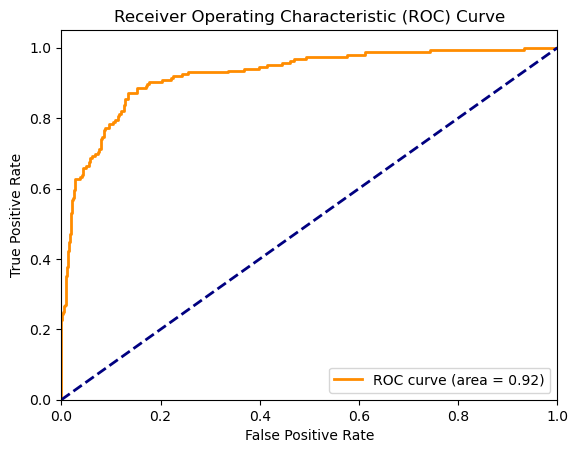

In [67]:
model_lr = LogisticRegression()
model_lr.fit(X, y)

y_score = model_lr.predict_proba(X)[:, 1]

fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### Fit Data To Model - Random Forest Classifier


In [66]:
from sklearn.linear_model import RidgeClassifier
std_reg = RidgeClassifier(alpha=8)
std_reg.fit(X_train, Y_train)
r2_train = std_reg.score(X_test, Y_test)

print("Score:")
print(r2_train)

Score:
0.8875


In [68]:
# X veri setindeki girdi özelliklerine dayanarak hedef değişkeni tahmin ediliyor.
Y_predict = std_reg.predict(X)
    
Y_predict

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,